#### Biography 
 - G. Strang, *Linear Algebra and Learning from Data*, Part VII (and bits of Part VI)
 - I. Goodfellow et al, *Deep learning*, Chapter 9 (https://www.deeplearningbook.org/contents/convnets.html)
 - http://colah.github.io/posts/2014-07-Conv-Nets-Modular/ (for a pictorial introduction) 
 - http://colah.github.io/posts/2014-07-Understanding-Convolutions/ (for more intuition on convolutions)
 
**Further Suggested reading:**
- https://amturing.acm.org/
- Deep learning. Authors Yann LeCun, Yoshua Bengio & Geoffrey Hinton. Nature volume 521, pages 436–444 (28 May 2015) (link: https://www.nature.com/articles/nature14539)
- https://hbr.org/2017/05/8-ways-machine-learning-is-improving-companies-work-processes
- https://hbr.org/sponsored/2019/03/is-your-organization-ready-to-implement-computer-vision-solutions

### Convolutional Neural Nets

Context:
Up to now, in the networks covered, each layer was fully connected to the next layer, so if one layer had $n$ neurons and the next layer $m$, then the matrix $A$ connecting those layers had size $m$ by $n$. *There were $mn$ independent weights in $A$*. The weights from all layers were chosen to give a final output that matched the training data. Now we might have only $3$ or $9$ independent weights per layer. 

*Convolutional networks* (or CNNs) are a specialised kind of neural network for processing data that has a known grid-like topology. Examples include
- Text and music (thought of as time series both have a 1D grid if sampled at regular time intervals)
- Images (have a 2D pixel grid structure)
- Videos (have a 3D grid consisting of pixels and time, or images in a time series)

The name "convolutional network" indicates that the network employs a mathematical operation called **convolution**. Convolution is a specialized kind of linear operation. *Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.*

#### The Convolution Operation  

Let's start with an example. Suppose we're tracking the location of a spaceship with a laser sensor. Our laser sensor provides a single output $x(t)$, the position of the spaceship at time $t$. Both $x$ and $t$ are real valued, that is, we can get a different reading from the laser sensor at any instant in time. 

Now suppose that our laser sensor is somewhat noisy. To obtain a less noisy estimate of the spaceship's position, we would like to average several measurements. Of course, more recent measurements are more relevant, so we will want this to be a weighted average that gives more weight to recent measurements. We can do this with a declining weighting function $w(a)$, where $a$ is the age of the measurement. The older the measurement, the smaller the weight (e.g. $w(a) \propto 1/a$). If we apply such a weighted average operation at every moment, we obtain a new function $s$ providing a smoothed estimate of the position of the spaceship: 
$$s(t) = \int_0^{\infty} x(a) w(t - a) da.$$

This operation is called a **convolution**, and it is typically denoted by 
$$s(t) = (x \ast w)(t).$$

In our example, $w$ needs to be a valid probability density function, or the output will not be a weighted average. Here and beyond in this session, $x$ is called the **input**, $w$ is called the **kernel** and the output is also sometimes referred to as the **feature map.**

In machine learning applications, we are often working with discretised signals (e.g. image pixels, finite samples of a sensor etc.) and the input is usually a multidimensional array of data, and the kernel is also usually a multidimensional array of parameters that are adapted by the learning algorithm. In one-dimension, the discrete convolution looks like:

$$S_{i} = (I\ast K)_{i} = \sum_n X(n) W(i - n).$$

For computer vision, we often use convolutions over more than one axis at a time. For example, if we use a two-dimensional image $X$ as our input, we probably also want to use a two-dimensional kernel $W$: 

$$S_{i, j} = (I\ast K)_{i, j} = \sum_n \sum_m X(m, n) W(i - m, j - m).$$

The summations as we shall see shortly are over a finite range of values (in practice that means that our multidimensional arrays, or *tensors* are zero beyond a finite range of indices). Let's see a concrete example of discrete convolution operator in one-dimension using *Toeplitz* or *circulant matrices*.

Consider $v = (v_0, v_1, \dots, v_5)$ and that our convolution consists of $y=Av=(y_1, y_2, y_3, y_4)$ where 

$$A =  \begin{bmatrix}
    x_1 & x_0 & x_{-1} & 0 & 0 & 0 \\
    0 & x_1 & x_0 & x_{-1} & 0 & 0 \\
    0 & 0 & x_1 & x_0 & x_{-1} & 0 \\
    0 & 0 & 0 & x_1 & x_0 & x_{-1} \\
  \end{bmatrix}
$$

Even though the discrete convolution operation can be represented as a matrix, each row of the matrix is constrained to be equal to the row above shifted by one elment. In two dimensions, a convolution corresponds to a **doubly block circular matrix** (matrix is sparse and has only a few distinct elements). The 2D case is slightly more complicated since we have to consider block matrices, where each matrix is a Toeplitz matrix, and we have to flatten our 2D image into one long 1D vector, which brings us back to the 1D case we've seen above. In practical terms we slide the 2D filter throughout the image, to create a new image. We multiply the entries in the filter by the corresponding pixels in the moving window and add them up. See the animation below. 

<img src="convolution_schematic.gif" alt="Drawing" style="width: 400px;"/>

**References:**

- http://deeplearning.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/

- https://dsp.stackexchange.com/questions/35373/2d-convolution-as-a-doubly-block-circulant-matrix-operating-on-a-vector

 #### Two-dimensional convolutional nets
 
Now we come to the real success of CNN's: **Image recognition.** CNNs and deep learning have a produced a small revolution in computer vision. The applications are to self-driving cars, drones, medical imaging, security, robotics etc 

As we discussed above, in two dimensions (for images) the matrix $A$ is block Toeplitz. Each small block is $E$ by $E$ where $E$ is the size of the circulant vector (e.g. in the example above the circulant vector had E=5). *But there are only $E$ independent entries in the convolution kernel.* This will lead to a major gain in computational efficiency. 

To understand an image, look to see where it changes. *Find the edges.* Our eyes look for sharp cutoffs and steep gradients. Our computer can do the same by creating a filter. And filters have many purposes, 
1. Smoothing (see `GaussianBlur` below)
2. Gradient Detection
3. Edge Detection etc

The example below is meant to illustrate these examples with a live script (try it yourself!). 

In [1]:
# if you want to see how the edge detection filters work 
# use this link: 
# 
import cv2 #pip install opencv-python
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img0 = cv2.imread('./gamblers.jpg',)

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray,(3,3),0)

# an image is just a 2D grid of numbers -- that's how your computer sees it
img, img.shape

(array([[ 25,  28,  32, ...,  46,  19,   5],
        [ 29,  33,  37, ...,  49,  20,   5],
        [ 37,  39,  41, ...,  52,  23,   6],
        ...,
        [ 39,  38,  37, ..., 105,  40,   7],
        [ 44,  42,  41, ..., 108,  41,   8],
        [ 45,  44,  42, ..., 110,  42,   9]], dtype=uint8),
 (387, 620))

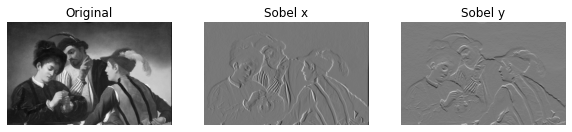

In [2]:
# convolute with proper kernels
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

f = plt.figure(figsize=(10,3))
ax0 = f.add_subplot(131)
ax1 = f.add_subplot(132)
ax2 = f.add_subplot(133)
# x = np.linspace(0,4,1000)
# ax.plot(x, np.sin(x))
# ax2.plot(x, np.cos(x), 'r:')

# original
ax0.imshow(img, cmap = 'gray')
ax0.set_title('Original')
ax0.axis('off')

# horizontal edges 
ax1.imshow(sobelx, cmap = 'gray')
ax1.set_title('Sobel x')
ax1.axis('off')

# vertical edges 
ax2.imshow(sobely, cmap = 'gray')
ax2.set_title('Sobel y')
ax2.axis('off')

plt.show()

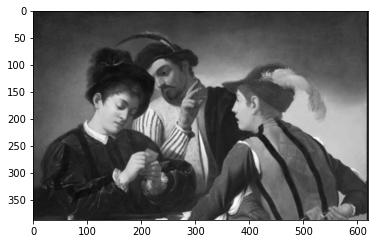

In [3]:
plt.imshow(img, cmap = 'gray')
plt.savefig('caravaggio-original.svg')

[[  3   4   0 ... -14 -27 -14]
 [  4   4   1 ... -13 -29 -15]
 [  2   2   1 ... -10 -29 -17]
 ...
 [ -1  -1   2 ... -34 -65 -33]
 [ -2  -1   1 ... -33 -67 -33]
 [ -1  -2   0 ... -34 -68 -33]] (387, 619)


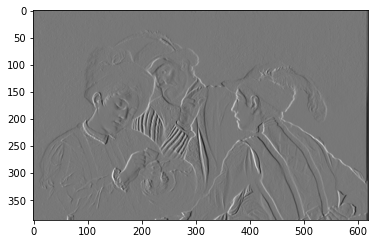

In [4]:
# try it yourself 
from scipy import signal as sg
# how would the vertical edge detector look like? 
h_edge = sg.convolve(img, [[1, -1]], "valid")
plt.imshow(h_edge, cmap = 'gray')
# compare this with the array we had originally 
print(h_edge, h_edge.shape)
plt.savefig('caravaggio-hedge.svg')

[[ 4  5  5 ...  3  1  0]
 [ 8  6  4 ...  3  3  1]
 [ 5  4  1 ...  0  1  1]
 ...
 [ 2  2  2 ...  0  0 -1]
 [ 5  4  4 ...  3  1  1]
 [ 1  2  1 ...  2  1  1]] (386, 620)


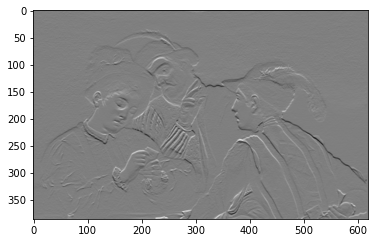

In [5]:
v_edge = sg.convolve(img, np.array([[1, -1]]).T, "valid")
plt.imshow(v_edge, cmap = 'gray')
# compare this with the array we had originally 
print(v_edge, v_edge.shape)
plt.savefig('caravaggio-vedge.svg')

[[ 739.5   730.    720.5  ... 1127.   1045.5   930.25]
 [ 759.25  747.5   737.   ... 1124.   1042.75  927.5 ]
 [ 773.5   759.5   748.5  ... 1122.5  1041.75  927.  ]
 ...
 [ 691.5   689.25  689.75 ... 2600.75 2399.25 2131.5 ]
 [ 720.    717.    716.75 ... 2670.25 2455.5  2173.5 ]
 [ 750.25  746.    744.75 ... 2704.75 2485.   2196.75]] (379, 612)


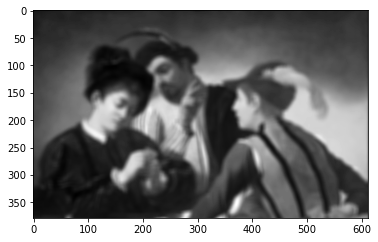

In [6]:
blurred = sg.convolve(img, np.full(shape=(9,9),fill_value=1./4.), "valid")
plt.imshow(blurred, cmap = 'gray')
# compare this with the array we had originally 
print(blurred, blurred.shape)
plt.savefig('caravaggio-blurred.svg')

#### The Stride of a Convolutional Filter

Another important concept for convolution filters is that of the *stride* length. The filters we've seen so far have stride $S=1$. For a larger stride, the *moving window takes longer steps* as it moves across the signal or image. Here is the matrix $A$ for a 1D, 3-weight filter with stride 2.  

$$\text{$S=2$: }A =
\begin{bmatrix}
    x_1 & x_0 & x_{-1} & 0 & 0 \\
    0 & 0 & x_1 & x_0 & x_{-1} \\
 \end{bmatrix}
$$

#### Pooling 

A typical layer of a convolutional network consists of three stages: 

1. Convolution: in this state several convolutions in parallel to produce a set of linear activations 
2. Detector: next, each linear activation is run through a nonlinear activation function (e.g. ReLu)
3. Pooling: in the third and last stage, we use a pooling function to modify the output layer further. 

A commonly used pooling function is **max pooling** which reports the maximum output within a rectangular patch of an image. There are other popular choices too. 

Pooling has several advantages: it reduces the dimension of the output and *reduces the possibility of overfitting*. One way to see this is that pooling helps make the representation approximately **invariant** to small translations of the input. Invariance to translation means that when determining whether an image contains or not a face, we do not know the location of the eyes with pixel-perfect accuracy, we just need to know that there is an eye on the left side of the face and an eye on the right side of the face. Moreover, pooling may add further **robustness** to the prediction models (intuitively, in average pooling we sum the values in those rectengular patches, so that the noises tend to cancel each other). 


<img src="max_pooling.png" alt="Drawing" style="width: 400px;"/>

<img src="pooling_schematic.gif" alt="Drawing" style="width: 400px;"/>

References: 
- [HOML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), chapter 13
- http://deeplearning.stanford.edu/tutorial/supervised/Pooling/

In [8]:
from numpy.lib.stride_tricks import as_strided


def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    '''
    2D Pooling (inspired from https://stackoverflow.com/a/54966908/8887428)

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window over which we take pool
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))

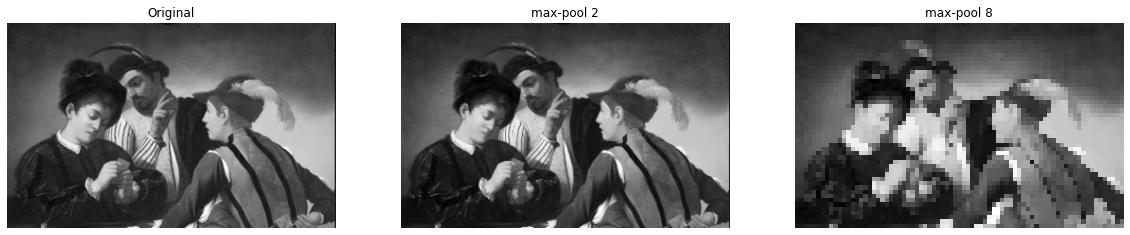

In [9]:
# back to Caravaggio's Gamblers

img_pool2 = pool2d(img, kernel_size=2, stride=2, padding=0, pool_mode='max')
img_pool8 = pool2d(img, kernel_size=8, stride=8, padding=0, pool_mode='max')

f = plt.figure(figsize=(20,6))
ax0 = f.add_subplot(131)
ax1 = f.add_subplot(132)
ax2 = f.add_subplot(133)
# x = np.linspace(0,4,1000)
# ax.plot(x, np.sin(x))
# ax2.plot(x, np.cos(x), 'r:')

# original
ax0.imshow(img, cmap = 'gray')
ax0.set_title('Original')
ax0.axis('off')

# a mild 2x2 max-pool
ax1.imshow(img_pool2, cmap = 'gray')
ax1.set_title('max-pool 2')
ax1.axis('off')

# a more aggressive 8x8 max-pool: image has an Atari feel to it now
ax2.imshow(img_pool8, cmap = 'gray')
ax2.set_title('max-pool 8')
ax2.axis('off')

plt.show()

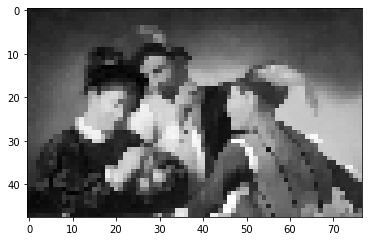

In [10]:
plt.imshow(img_pool8, cmap = 'gray')
# compare this with the array we had originally 
plt.savefig('caravaggio-pixel.svg')

In [11]:
img.shape

(387, 620)

In [12]:
img_pool8.shape

(48, 77)

#### Neuroscientific principles: the architecture of the visual cortex

David H. Hubel and Torsten Wiesel performed a series of experiments on cats in 1964 (and a few years later on monkeys), giving crucial insights on the structure of the visual cortex (the authors received the Nobel Prize in Physiology or Medicine in 1981 for their work). 

In particular, they showed that many neurons in the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field (see the figure below, in which the local receptive fields of five neurons are represented by dashed circles). 

The receptive fields of different neurons may overlap, and together they tile the whole visual field. Moreover, the authors showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations). They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons (notice in the figure that each neuron is connected only to a few neurons from the previous layer). This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field.

<img src="visual_cortex.png" alt="Drawing" style="width: 400px;"/>

Figure extracted from Geron's [HOML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

#### The World Championship at the Game of Go
A dramatic achievement by a deep convolutional network was to defeat the human world champion at Go. This is a difficult game played on a 19 by 19 board. In turn, two players put down "stones" in attempting to surround those of the oponent. 

AlphaGo (Google's deep CNN) defeated player Lee Sedol by $4 \times 1$ in 2016. It had trained on thousands of human games. You can read [more](https://en.wikipedia.org/wiki/AlphaGo_versus_Lee_Sedol).

### Industry applications 
- Drone and satellite-based asset management
- Manufacturers are using computer vision to allow their robots to operate safely side-by-side with humans inside factories.
- Healthcare organizations are using computer vision to annotate x-rays and quickly identify pathologies, increasing diagnostic accuracy and decreasing liability.
- Construction firms are using computer vision to scan structures under construction to track progress and to avoid time-consuming inspections and costly rework.
- Precision agriculture/targeted pest constrol (e.g.: Imago AI)

### Extra: Interview Questions
*** 

**Heard in the Data Science Interview:** 
1. What is an Artificial Neural Network (ANN)? How to train an ANN? What is backpropagation? 
2. How does a neural network with three layers (one input layer, one hidden layer, and one output layer) compare to logistic regression? 
3. What is the activation function in ANN? What are some of the functions used for this? 
4. Why do we need activation functions in the neural network design? 
5. What is deep learning and what are some of the main characteristics that distinguish it from traditional ML? 
6. I'm trying to fit a single hidden layer neural network to a given dataset, and I find that the weights are oscillating a lot over training iterations -- varying wildly, often swinging between positive and negative values. What parameter do I need to tune to address this issue? 

***